We want to convert the routines below to use the BasicCameraGUI as the base and test with the existing polar mapping methods.

In [1]:
import numpy as np
from src.visualisers.camera_gui import BasicCameraGUI, display, DecomposeFrame

In [2]:
from src.sources.polar_mapping import (
    generateLUT, setup_reduced_res, reduce_resolution, convert_image, forward_quad
)

In [3]:
class PolarGUI(BasicCameraGUI):
    """Convert base camera into polar co-ordinates."""
    
    def __init__(self, src=0, phase_width=256):
        # Call parent init
        super().__init__(src)
        
        # Capture a frame to set image sizes
        _, frame = self.cam.read()
        Y = frame[:, :, 0]
        self.centre = np.asarray(Y.shape) // 2
        self.radius = self.centre.max()
        self.phase_width = phase_width
        # Generate LUT
        self.LUT = generateLUT(self.radius, phase_width=phase_width)
        
    def update_image(self):
        # Get frame
        (readsuccessful, frame) = self.cam.read()
        Y = frame[:, :, 0]
        converted = convert_image(Y, self.LUT)
        display(converted, self.original_image)
        return converted

In [4]:
polar = PolarGUI()
polar.run()

This appears to work.
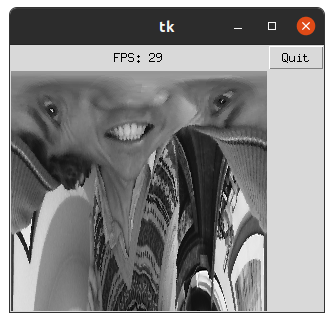

Now we want to split the visual field - does our forward quad do this?

In [33]:
class QuadPolar(PolarGUI):
    """Show different portions of visual field."""
    def __init__(self, src=0, phase_width=256):
        # Call parent init
        super().__init__(src, phase_width)
        
        # Add a decompose frame to show quad
        self.frame = DecomposeFrame(self.window, width=128, height=128)
        
    def update_image(self):
        # Get frame
        converted = super().update_image()
        images = forward_quad(converted)
        self.frame.update(images)
        return converted

In [34]:
qp = QuadPolar()
qp.run()

Now need to convert this last reduced GUI...

In [7]:
import tkinter as tk

class CamGUIReduced(QuadPolar):

    def __init__(self, src=0, phase_width=256):
        # Call parent init
        super().__init__(src, phase_width)
        # Setup reduced resolution parameters
        self.precomputed = setup_reduced_res(self.phase_width)
        # frame and label for the reduced resolution frame
        reduced_frame = tk.Frame(self.window)
        reduced_frame.pack(side=tk.LEFT, expand=True, fill=tk.BOTH)
        self.reduced_image = tk.Label(reduced_frame)
        self.reduced_image.pack(padx=5, pady=5)

    def update_image(self):
        converted = super().update_image()
        # Show reduced image
        output_list, output_image = reduce_resolution(
            converted, output_display=True, precomputed=self.precomputed)
        display(output_image, self.reduced_image)
        return converted

In [8]:
reduced = CamGUIReduced()
reduced.run()

Now let's try polar and decomposition and PBT?

We need to mix DeComGUI and PolarGUI. Better to expand the polar GUI?

Let's first make DeComGUI inherit from BasicCameraGUI

In [23]:
import cv2
from src.var_processor.surface_stage import decompose

class DeComGUI(BasicCameraGUI):
    """GUI to look at decompositions."""

    def __init__(self, src=0, stages=7):
        # Call parent init
        super().__init__(src)

        # Hardcode decomposition stages for now
        self.num_of_stages = stages

        # Create a frame for each stage and pack vertically
        self.frames = [
            DecomposeFrame(self.window, width=128, height=128)
            for _ in range(self.num_of_stages)]

    def update_image(self):
        # Get frame
        (readsuccessful, frame) = self.cam.read()
        Y = frame[:, :, 0]
        image = Y
        image_lists = [[Y]]
        # Iteratively decompose
        for _ in range(self.num_of_stages - 1):
            # Convert to 16-bit to avoid overflow
            images = decompose(image.astype(np.int16))
            # Scale and convert back to 8-bit
            # Convert A to unsigned 8 bit
            images[0] = (images[0]).astype(np.uint8)
            # For others shift to positive and apply colour map
            # heatmap = cv2.applyColorMap(image, cv2.COLORMAP_HOT)
            images = [images[0]] + [
                cv2.applyColorMap((i + 128).astype(np.uint8), cv2.COLORMAP_JET) for i in images[1:]
            ]
            image_lists.append(images)
            # Set the next image as the average of the set
            image = images[0]

        for frame, image_list in zip(self.frames, image_lists):
            frame.update(image_list)
        return Y

In [24]:
decom = DeComGUI()
decom.run()

In [25]:
from src.var_processor.pb_threshold import pb_threshold, pb_residual_threshold

class PBTDeComGUI(DeComGUI):
    """Apply PBT to the surfaces (separately to A and differences)."""

    def update_image(self):
        # Get frame
        (readsuccessful, frame) = self.cam.read()
        Y = frame[:, :, 0]
        image = Y
        image_lists = [[Y]]
        # Iteratively decompose
        for _ in range(self.num_of_stages + 4 - 1):
            # Convert to 16-bit to avoid overflow
            images = decompose(image.astype(np.int16))
            # Set A as input for next stage
            image = images[0]
            # PBT A - remember to cast to 8-bit
            A_pbt = pb_threshold(images[0].astype(np.uint8)) * 255
            # PBT differences
            diffs = list()
            for i in images[1:]:
                thresholded = pb_residual_threshold(i)
                rescaled = (thresholded * 127) + 127
                color_mapped = cv2.applyColorMap(rescaled.astype(np.uint8), cv2.COLORMAP_JET)
                diffs.append(color_mapped)
            images = [A_pbt.astype(np.uint8)] + diffs
            image_lists.append(images)

        for frame, image_list in zip(self.frames, image_lists):
            frame.update(image_list)
        return Y

In [27]:
pb_decom = PBTDeComGUI(stages=7)
pb_decom.run()

Exception in Tkinter callback
Traceback (most recent call last):
  File "/home/ben/anaconda3/envs/ml_platform_3_7/lib/python3.7/tkinter/__init__.py", line 1705, in __call__
    return self.func(*args)
  File "/home/ben/anaconda3/envs/ml_platform_3_7/lib/python3.7/tkinter/__init__.py", line 749, in callit
    func(*args)
  File "/home/ben/Projects/var_processor/src/visualisers/camera_gui.py", line 89, in <lambda>
    self.window.after(20, func=lambda: self.update_all())
  File "/home/ben/Projects/var_processor/src/visualisers/camera_gui.py", line 88, in update_all
    self.update_fps()
  File "/home/ben/Projects/var_processor/src/visualisers/camera_gui.py", line 82, in update_fps
    self.fps_label.configure(text=f'FPS: {fps}')
  File "/home/ben/anaconda3/envs/ml_platform_3_7/lib/python3.7/tkinter/__init__.py", line 1485, in configure
    return self._configure('configure', cnf, kw)
  File "/home/ben/anaconda3/envs/ml_platform_3_7/lib/python3.7/tkinter/__init__.py", line 1476, in _confi

Use PolarGUI as base and add in methods from the DeComPBT...

In [35]:
class PolarPBT(PolarGUI):
    
    def __init__(self, src=0, stages=7):
        # Call parent init
        super().__init__(src)

        # Hardcode decomposition stages for now
        self.num_of_stages = stages

        # Create a frame for each stage and pack vertically
        self.frames = [
            DecomposeFrame(self.window, width=128, height=128)
            for _ in range(self.num_of_stages)]
        
    def update_image(self):
        # Get frame
        converted = super().update_image()
        image = converted
        image_lists = [[image]]
        # Iteratively decompose
        for _ in range(self.num_of_stages + 4 - 1):
            # Convert to 16-bit to avoid overflow
            images = decompose(image.astype(np.int16))
            # Set A as input for next stage
            image = images[0]
            # PBT A - remember to cast to 8-bit
            A_pbt = pb_threshold(images[0].astype(np.uint8)) * 255
            # PBT differences
            diffs = list()
            for i in images[1:]:
                thresholded = pb_residual_threshold(i)
                rescaled = (thresholded * 127) + 127
                color_mapped = cv2.applyColorMap(rescaled.astype(np.uint8), cv2.COLORMAP_JET)
                diffs.append(color_mapped)
            images = [A_pbt.astype(np.uint8)] + diffs
            image_lists.append(images)

        for frame, image_list in zip(self.frames, image_lists):
            frame.update(image_list)
        return converted

In [38]:
ppb_decom = PolarPBT(stages=4)
ppb_decom.run()

Exception in Tkinter callback
Traceback (most recent call last):
  File "/home/ben/anaconda3/envs/ml_platform_3_7/lib/python3.7/tkinter/__init__.py", line 1705, in __call__
    return self.func(*args)
  File "/home/ben/anaconda3/envs/ml_platform_3_7/lib/python3.7/tkinter/__init__.py", line 749, in callit
    func(*args)
  File "/home/ben/Projects/var_processor/src/visualisers/camera_gui.py", line 89, in <lambda>
    self.window.after(20, func=lambda: self.update_all())
  File "/home/ben/Projects/var_processor/src/visualisers/camera_gui.py", line 88, in update_all
    self.update_fps()
  File "/home/ben/Projects/var_processor/src/visualisers/camera_gui.py", line 82, in update_fps
    self.fps_label.configure(text=f'FPS: {fps}')
  File "/home/ben/anaconda3/envs/ml_platform_3_7/lib/python3.7/tkinter/__init__.py", line 1485, in configure
    return self._configure('configure', cnf, kw)
  File "/home/ben/anaconda3/envs/ml_platform_3_7/lib/python3.7/tkinter/__init__.py", line 1476, in _confi

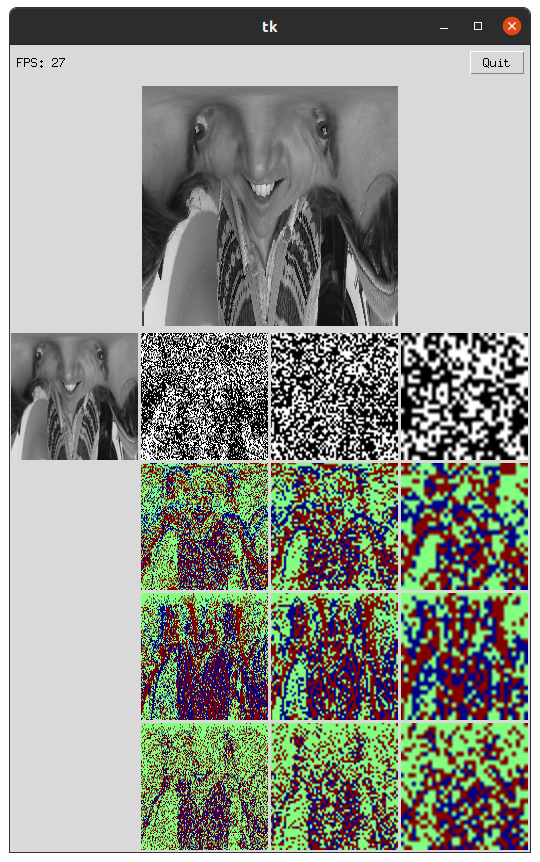

Todo:
* Diffs as another stage in between.
* Reconstruction in parallel.
* Toggle components of reconstruction.
* Break into quadrants.

In [ ]:
class PBTPolarQuad((PolarGUI):
    """Show different portions of visual field."""
    def __init__(self, src=0, phase_width=256):
        # Call parent init
        super().__init__(src, phase_width)
        
        # Add a decompose frame to show quad
        self.quad_frame = DecomposeFrame(self.window, width=128, height=128)
                   
        
        
    def update_image(self):
        # Get frame
        converted = super().update_image()
        images = forward_quad(converted)
        self.frame.update(images)
        return converted